## Processo de Machine Learning

In [1]:
# importando os módulos

import pandas as pd
import datetime
import glob
from minio import Minio
import numpy as np
import matplotlib.pyplot as plt

## Baixando o Dataset do Data Lake

In [2]:
# Conexão com o datalaKe

client = Minio(
        "localhost:9000",
        access_key="minioadmin",
        secret_key="minioadmin",
        secure=False
    )

In [3]:
# baixando o data frame final
client.fget_object(
            "processing",
            "employees_dataset.parquet",
            "temp_.parquet",
)
df = pd.read_parquet("temp_.parquet")

In [4]:
df.head()

,department,salary,left,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident
0,sales,low,1.0,266.000000,2.0,38.0,53.0,3.0,0.0
1,sales,medium,1.0,252.000000,5.0,80.0,86.0,6.0,0.0
2,sales,medium,1.0,289.666667,7.0,11.0,88.0,4.0,0.0
3,sales,low,1.0,275.666667,5.0,72.0,87.0,5.0,0.0
4,sales,low,1.0,292.333333,2.0,37.0,52.0,3.0,0.0


## Manipulação dos dados

In [5]:
# Reordenando o dataset

df = df[['department', 'salary', 'mean_work_last_3_months',
       'number_projects', 'satisfaction_level', 'last_evaluation',
       'time_in_company', 'work_accident','left']]

In [6]:
df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266.000000,2.0,38.0,53.0,3.0,0.0,1.0
1,sales,medium,252.000000,5.0,80.0,86.0,6.0,0.0,1.0
2,sales,medium,289.666667,7.0,11.0,88.0,4.0,0.0,1.0
3,sales,low,275.666667,5.0,72.0,87.0,5.0,0.0,1.0
4,sales,low,292.333333,2.0,37.0,52.0,3.0,0.0,1.0


In [7]:
# verificando missing values

df.isnull().sum()

department                 1
salary                     1
mean_work_last_3_months    0
number_projects            1
satisfaction_level         1
last_evaluation            1
time_in_company            1
work_accident              1
left                       1
dtype: int64

In [8]:
# Removendo missing

df.dropna(axis = 0, inplace = True)

In [9]:
# verificando missing values

df.isnull().sum()

department                 0
salary                     0
mean_work_last_3_months    0
number_projects            0
satisfaction_level         0
last_evaluation            0
time_in_company            0
work_accident              0
left                       0
dtype: int64

In [10]:
# Verificando o tipo dos dados

df.dtypes

department                  object
salary                      object
mean_work_last_3_months    float64
number_projects            float64
satisfaction_level         float64
last_evaluation            float64
time_in_company            float64
work_accident              float64
left                       float64
dtype: object

In [11]:
## Alterando os dados necessários

from numpy import int64

df["number_projects"] = df["number_projects"].astype(int64)
df["mean_work_last_3_months"] = df["mean_work_last_3_months"].astype(int64)
df["time_in_company"] = df["time_in_company"].astype(int64)
df["work_accident"] = df["work_accident"].astype(int64)
df["left"] = df["left"].astype(int64)

In [12]:
df.dtypes

department                  object
salary                      object
mean_work_last_3_months      int64
number_projects              int64
satisfaction_level         float64
last_evaluation            float64
time_in_company              int64
work_accident                int64
left                         int64
dtype: object

In [13]:
# Renomeando os atributos

df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_projects': 'projectCount',
                        'mean_work_last_3_months': 'averageMonthlyHours',
                        'time_in_company': 'yearsAtCompany',
                        'work_accident': 'workAccident',
                        'left' : 'turnover'
                        })

# Pré processamento dos dados

In [14]:
df.head()

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


In [15]:
# Convertendo atributos categóricos Cat.codes

df["department"] = df["department"].astype('category').cat.codes
df["salary"] = df["salary"].astype('category').cat.codes

# 
df["department"] = df["department"].astype(int64)
df["salary"] = df["salary"].astype(int64)

In [16]:
df.head()

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,7,1,266,2,38.0,53.0,3,0,1
1,7,2,252,5,80.0,86.0,6,0,1
2,7,2,289,7,11.0,88.0,4,0,1
3,7,1,275,5,72.0,87.0,5,0,1
4,7,1,292,2,37.0,52.0,3,0,1


## Feature importances

In [18]:
# Separando os dados em treino e teste

X = df.drop('turnover', axis=1)
y = df['turnover']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [19]:
# importando extra-Trees

from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier()

et.fit(X_train,y_train)

ExtraTreesClassifier()

In [20]:
# coletando as variáveis mais importantes

importances = et.feature_importances_
feat_names = df.drop(['turnover'],axis=1).columns

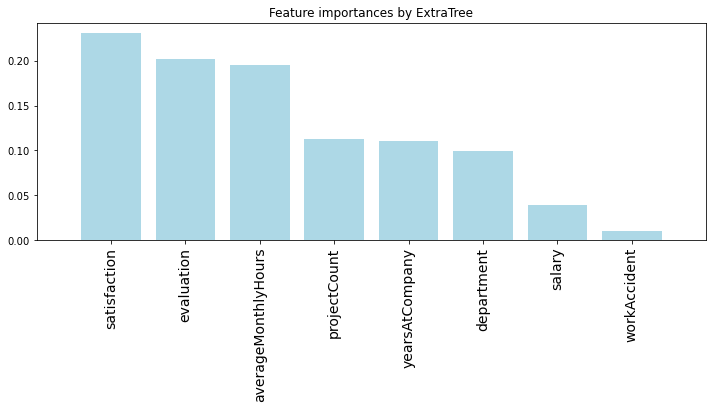

In [22]:
# Plotagem da features importances

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,4))
plt.title("Feature importances by ExtraTree")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

## Construção e validação do modelo com Pycaret (Auto-ML)

In [23]:
# importando o módulo

from pycaret.classification import *

In [24]:
# definindo o Setup com os atributos importantes

s = setup( df[["satisfaction","evaluation","averageMonthlyHours","projectCount","yearsAtCompany","turnover"]]
          ,target = "turnover"
          ,numeric_features = ["satisfaction","evaluation","averageMonthlyHours","projectCount","yearsAtCompany"]
          ,normalize = True
          ,normalize_method = "zscore" #standardize
          ,data_split_stratify = True
          ,fix_imbalance = True,
         )

,Description,Value
0,session_id,562
1,Target,turnover
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(14999, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Comparando os melhores modelos

In [25]:
best = compare_models(fold = 5, sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8097,0.7806,0.7533,0.8161,0.8124,0.4914,0.4922,0.3660
catboost,CatBoost Classifier,0.8288,0.7696,0.7540,0.8257,0.8270,0.5186,0.5191,3.0040
lightgbm,Light Gradient Boosting Machine,0.8255,0.7675,0.7527,0.8234,0.8243,0.5124,0.5128,0.1240
ada,Ada Boost Classifier,0.7645,0.7668,0.7378,0.7979,0.7755,0.4231,0.4329,0.1540
xgboost,Extreme Gradient Boosting,0.8163,0.7618,0.7265,0.8097,0.8122,0.4723,0.4739,0.5160
qda,Quadratic Discriminant Analysis,0.7181,0.7500,0.7120,0.7799,0.7358,0.3531,0.3727,0.0240
rf,Random Forest Classifier,0.7951,0.7492,0.6971,0.7874,0.7905,0.4113,0.4127,0.5380
knn,K Neighbors Classifier,0.7063,0.7273,0.6950,0.7684,0.7246,0.3252,0.3429,0.5500
et,Extra Trees Classifier,0.7860,0.7209,0.6844,0.7778,0.7811,0.3847,0.3861,0.4480
nb,Naive Bayes,0.6992,0.7141,0.6680,0.7501,0.7161,0.2884,0.2996,0.0180


## criando o modelo

In [26]:
# treina o modelo com 5 folds

gbc = create_model('gbc', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8095,0.8022,0.7519,0.8154,0.8121,0.4897,0.4904
1,0.8138,0.7777,0.7541,0.8180,0.8157,0.4975,0.4979
2,0.8052,0.7762,0.7491,0.8126,0.8084,0.4814,0.4824
3,0.8143,0.7765,0.7551,0.8186,0.8162,0.4991,0.4996
4,0.8056,0.7702,0.7563,0.8159,0.8098,0.4890,0.4909
Mean,0.8097,0.7806,0.7533,0.8161,0.8124,0.4914,0.4922
SD,0.0039,0.0111,0.0025,0.0021,0.0031,0.0064,0.0061


In [27]:
## Tunning do modelo gradient boosting

tuned_gbc = tune_model(gbc
                      ,fold = 5
                      ,custom_grid = {"learning_rate":[0.1,0.2,0.5]
                                     ,"n_estimators":[100,500,1000]
                                     ,"min_samples_split":[1,2,5,10]
                                     ,"max_depth":[1,3,9]
                                     }
                      ,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7624,0.7800,0.7409,0.7995,0.7742,0.4239,0.4355
1,0.7710,0.7740,0.7404,0.8001,0.7809,0.4323,0.4405
2,0.7486,0.7712,0.7374,0.7967,0.7629,0.4066,0.4228
3,0.7486,0.7662,0.7360,0.7958,0.7627,0.4052,0.4208
4,0.7575,0.7668,0.7398,0.7985,0.7702,0.4179,0.4311
Mean,0.7576,0.7717,0.7389,0.7981,0.7702,0.4171,0.4301
SD,0.0085,0.0051,0.0019,0.0016,0.0069,0.0103,0.0075


**Não conseguimos nenhuma melhora significativa como tunning.**

## Salvando o modelo final em disco

In [28]:
final_model = finalize_model(gbc)

In [29]:
# salvando o modelo no formato pKl

save_model(final_model,'model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['satisfaction',
                                                           'evaluation',
                                                           'averageMonthlyHours',
                                                           'projectCount',
                                                           'yearsAtCompany'],
                                       target='turnover', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy=...
                                             learning_rate=0.1, loss='deviance',
                                             max_depth=

## Transferindo os arquivos finais para o data lake

In [30]:
# salvando modelo no data laKe

client.fput_object(
    "curated",
    "model.pkl",
    "model.pkl"
)

In [32]:
# salvando o dataset final

df.to_csv("ml_dataset.csv",index=False)

client.fput_object(
    "curated",
    "ml_dataset.csv",
    "ml_dataset.csv"
)